In [28]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

from icedef import timestepper, drift, metocean, iceberg, interpolate, tools

In [2]:
time_stepper = timestepper.euler
interpolator = interpolate.UniformRegularLinearInterpolator
drift_model = drift.DynamicDriftModel
ocean_model = 'ECMWF'
atmosphere_model = 'ECMWF'

# Load in Metocean Data

In [4]:
start_date = np.datetime64('2015-04-23')
end_date = start_date + np.timedelta64(1, 'D')
date_bounds = start_date, end_date

In [5]:
ocean = metocean.Ocean(date_bounds, model=ocean_model, interpolator=interpolator)
atmosphere = metocean.Atmosphere(date_bounds, model=atmosphere_model, interpolator=interpolator)

# Create Iceberg

In [6]:
iceberg_start_time = start_date + np.timedelta64(1, 'h')
iceberg_start_position = 50, -50
iceberg_start_velocity = 0, 0
iceberg_ = iceberg.quickstart(iceberg_start_time, iceberg_start_position, iceberg_start_velocity)

# Simulate with Dynamic Drift Model

In [24]:
drift_model_kwargs = {
    'form_drag_coefficient_in_air': iceberg_.FORM_DRAG_COEFFICIENT_IN_AIR,
    'form_drag_coefficient_in_water': iceberg_.FORM_DRAG_COEFFICIENT_IN_WATER,
    'skin_drag_coefficient_in_air': iceberg_.SKIN_DRAG_COEFFICIENT_IN_AIR,
    'skin_drag_coefficient_in_water': iceberg_.SKIN_DRAG_COEFFICIENT_IN_WATER,
    'sail_area': iceberg_.geometry.sail_area,
    'keel_area': iceberg_.geometry.keel_area,
    'top_area': iceberg_.geometry.top_area,
    'bottom_area': iceberg_.geometry.bottom_area,
    'mass': iceberg_.geometry.mass,
}

drift_model = drift.DynamicDriftModel
drift_model = drift_model()
drift_function = drift_model.drift

In [25]:
#%%timeit

time_step = np.timedelta64(300, 's')
dt = time_step.item().total_seconds()

simulation_start_time = iceberg_start_time
simulation_end_time = simulation_start_time + np.timedelta64(1, 'D')

time = simulation_start_time
iceberg_position = iceberg_start_position
iceberg_velocity = iceberg_start_velocity

dynamic_results = {'latitude': [iceberg_start_position[0]], 'longitude': [iceberg_start_position[1]]}

while time <= simulation_end_time:
    
    point = time, iceberg_position[0], iceberg_position[1]
    
    drift_function_kwargs = {
        'current_velocity': ocean.current.interpolate(point),
        'mean_current_velocity': ocean.current.interpolate(point),
        'mean_current_acceleration': (0, 0),
        'wind_velocity': atmosphere.wind.interpolate(point),
        'latitude': iceberg_start_position[0],
    }
    
    dx, dy, dvx, dvy = time_stepper(drift_model.drift, dt, iceberg_velocity, **drift_function_kwargs)
    
    iceberg_eastward_velocity, iceberg_northward_velocity = iceberg_velocity
    iceberg_eastward_velocity += dvx
    iceberg_northward_velocity += dvy
    iceberg_velocity = iceberg_eastward_velocity, iceberg_northward_velocity
    iceberg_latitude, iceberg_longitude = iceberg_position
    iceberg_latitude += tools.dy_to_dlat(dy)
    iceberg_longitude += tools.dx_to_dlon(dx, iceberg_latitude)
    iceberg_position = iceberg_latitude, iceberg_longitude
    
    dynamic_results['latitude'].append(iceberg_position[0])
    dynamic_results['longitude'].append(iceberg_position[1])
    
    time += time_step

# Simulate with Analytical Drift Model

In [26]:
drift_model_kwargs = {
    'form_drag_coefficient_in_air': iceberg_.FORM_DRAG_COEFFICIENT_IN_AIR,
    'form_drag_coefficient_in_water': iceberg_.FORM_DRAG_COEFFICIENT_IN_WATER,
    'length': iceberg_.geometry.waterline_length,
    'width': iceberg_.geometry.waterline_length,
}

drift_model = drift.AnalyticalDriftModel
drift_model = drift_model()
drift_function = drift_model.drift

In [27]:
#%%timeit

time_step = np.timedelta64(300, 's')
dt = time_step.item().total_seconds()

simulation_start_time = iceberg_start_time
simulation_end_time = simulation_start_time + np.timedelta64(1, 'D')

time = simulation_start_time
iceberg_position = iceberg_start_position

analytical_results = {'latitude': [iceberg_start_position[0]], 'longitude': [iceberg_start_position[1]]}


while time <= simulation_end_time:
    
    point = time, iceberg_position[0], iceberg_position[1]
    
    drift_function_kwargs = {
        'current_velocity': ocean.current.interpolate(point),
        'wind_velocity': atmosphere.wind.interpolate(point),
        'latitude': iceberg_position[0],
    }
    
    dx, dy = time_stepper(drift_model.drift, dt, **drift_function_kwargs)
    
    iceberg_latitude, iceberg_longitude = iceberg_position
    iceberg_latitude += tools.dy_to_dlat(dy)
    iceberg_longitude += tools.dx_to_dlon(dx, iceberg_latitude)
    iceberg_position = iceberg_latitude, iceberg_longitude
    
    analytical_results['latitude'].append(iceberg_position[0])
    analytical_results['longitude'].append(iceberg_position[1])
    
    time += time_step

# Plot Simulation Results

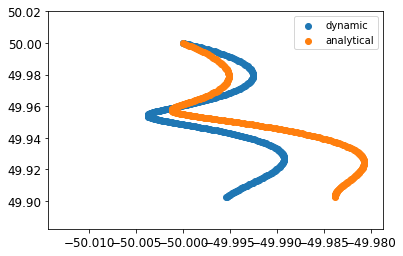

In [30]:
plt.scatter(dynamic_results['longitude'], dynamic_results['latitude'], label='dynamic')
plt.scatter(analytical_results['longitude'], analytical_results['latitude'], label='analytical')
plt.legend()
plt.show()